# Objectives
* Describe the output of a decision tree to someone without a data science background
* Describe how the algorithm creates the decision tree
* Predict the likelihood of a binary event using the decision tree
algorithm in scikit-learn
* Create a decision tree visualization
* Determine the optimal tree size using cross-validation and the AUC metric in Python
* Describe the strengths and weaknesses of a decision tree

# What is a Decision Tree?
* A supervised learning technique that can be used for discrete and continuous output.
* Visually engaging and easy to interpret.
* Excellent model for someone transitioning into the world of data
science.
* Foundational to learning some very powerful techniques.
* Are prone towards high-variance.
* We will focus on the CART algorithm.

Best place to start understanding decision trees is to look at one of them. The diagram below shows a decision tree trained on the titanic data set.

![](./interpretable_tree.png)
**Basic Interpretation**
* Decision Trees are made up of interconnected nodes, which act as a series of questions / test conditions (e.g., is the passenger male or female?)
* Nodes show the output metric, in this case the number of titanic survivors/deaths for a given combination of variables.
* Rule of thumb #1: The higher up the tree a variable is, the most important it is
* Rule of thumb #2: The more frequently a variable appears, the more important it is

**This raises questions**
* How does the algorithm choose which variables to include on the tree?
* How does the algorithm choose where variables should be located on the tree?
* How does the algorithm choose when to stop the tree?

# How is a Decision Tree Fit?

**The Algorithm, Introduced**

Different variables and split options are evaluated to determine which split will provide the greatest separation between classes. Of the the following three options, which would you choose of the following three options and why?
![](./tree_candidates.png)

How can we determine the best split analytically?

**Measuring Purity**

For classification, nodes are chosen based upon a reduction in impurity, often calculated as the gini impurity. This is defined as the following, where m is the node, k is the class level (e.g., survived, died), and p is the probability associated with a class at a given node. 
![](./GiniFormula.png)
Source: [scikit-learn documentation](http://scikit-learn.org/stable/modules/tree.html#classification-criteria)

Here is an example using this formula (no matrix math):

In [1]:
def calc_gini(n_class1, n_class2, n):
    gini = n_class1 / n * (1  - n_class1 / n) + n_class2 / n * (1  - n_class2 / n)
    return(gini)

calc_gini(396, 227, 623)

0.46320682041280087

In [2]:
n = 500
gini = [calc_gini(n_class1, n - n_class1, n) for n_class1 in list(range(0, n, 10))]

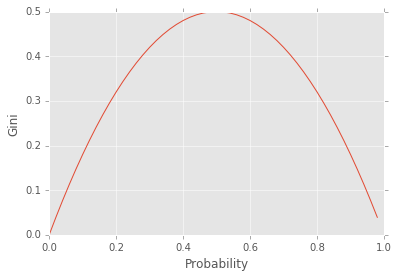

In [3]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

proportion = [n_class1 / n for n_class1 in list(range(0, n, 10))]
plt.plot(proportion, gini)
plt.xlabel('Probability')
plt.ylabel('Gini')
plt.show()

** Interpretation**

A Gini index of 0.5 indicates equal representation between both classes, and a Gini index of 0 indicates perfect separation between classes (i.e., perfect purity)

# An Overview of the Algorithm
1. Calculate the purity of the data
2. Select a candidate split
3. Calculate the purity of the data after the split
4. Repeat for all variables
5. Choose the variable with the greatest increase in purity 
6. Repeat for each split until some stop criteria is met

# Fitting a Decision Tree Classifer

In [4]:
from sklearn import tree
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib

In [5]:
%matplotlib inline
matplotlib.style.use('ggplot')
pd.set_option("max_r",10)

**Exercise: Data Processing**
* Read titanic.csv into memory
* Choose the features you will use for your first model
* Check for missing values in all columns
* Fill in missing values with the mean value (resource: [pandas documentation](http://pandas.pydata.org/pandas-docs/stable/missing_data.html#cleaning-filling-missing-data) on missing values)
* Convert all variables to numeric for scikit learn
* Create a proxy variable representing whether the Spouse was on board
* Write data out to ../data/titanic_modified.csv for later usage
* Split the data into train and test sets

If you finish early, spend time exploring the data to identify trends in characteristics of survivors

In [6]:
# Read titanic.csv into memory


In [7]:
# Choose the features you will use for your first model


In [8]:
# Subset the dataframe to only include the features you will include


In [9]:
# Check for missing values in all columns


In [10]:
# Fill in missing values


In [11]:
# Convert all variables to numeric so for scikit learn


In [12]:
# Create a proxy variable representing whether the Spouse was on board


In [13]:
# Write data out to ../data/titanic_modified.csv for later usage


In [63]:
# Now, split the data into training and test sets


**Solutions: Data Processing**

In [19]:
# Read titanic.csv into memory
import pandas as pd
d = pd.read_csv('titanic.csv')

In [20]:
# Choose the features you will use for your first model
features = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch']

In [21]:
# Subset the dataframe to only include the features you will include
d = d.loc[:,features]

In [22]:
d.head()

Survived  Pclass     Sex   Age  SibSp  Parch
0         0       3    male  22.0      1      0
1         1       1  female  38.0      1      0
2         1       3  female  26.0      0      0
3         1       1  female  35.0      1      0
4         0       3    male  35.0      0      0

In [23]:
# Check for missing values in all columns
d.isnull().sum(axis=0)

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
dtype: int64

In [24]:
# I'm also looking at the distribution across passengers
d.groupby(['Sex', 'Pclass']).Age.apply(lambda x: x.isnull().sum() / x.count())

Sex     Pclass
female  1         0.105882
        2         0.027027
        3         0.411765
male    1         0.207921
        2         0.090909
        3         0.371542
Name: Age, dtype: float64

In [25]:
# I'm also creating a feature that represents cases where the age is missing
d['MissingAge'] = d['Age'].isnull().astype(int)

In [26]:
d.groupby(['Sex', 'Pclass']).Age.transform(lambda x: x.mean())

0      26.507589
1      34.611765
2      21.750000
3      34.611765
4      26.507589
         ...    
886    30.740707
887    34.611765
888    21.750000
889    41.281386
890    26.507589
Name: Age, dtype: float64

In [27]:
d.groupby(['Sex', 'Pclass']).Age.apply(lambda x: x.mean())

Sex     Pclass
female  1         34.611765
        2         28.722973
        3         21.750000
male    1         41.281386
        2         30.740707
        3         26.507589
Name: Age, dtype: float64

In [28]:
# Fill in missing values
# I'm filling in with the average age for each class, gender combination
d['Age'] = d.groupby(['Sex', 'Pclass']).Age.transform(lambda x: x.fillna(x.mean()))

In [29]:
# Fill in missing values
# I'm filling in with the average age for each class, gender combination
d.Age.fillna(d.Age.mean())

0      22.00
1      38.00
2      26.00
3      35.00
4      35.00
       ...  
886    27.00
887    19.00
888    21.75
889    26.00
890    32.00
Name: Age, dtype: float64

In [30]:
# Convert all variables to numeric so for scikit learn
d['Sex'] = np.where(d['Sex'] == 'female', 0, 1)

In [31]:
# Create a proxy variable representing whether the Spouse was on board
d['Spouse'] = ((d.Age > 18) & (d.SibSp >= 1)).astype(int)

In [32]:
# Write data out to ../data/titanic_modified.csv for later usage
d.to_csv('titanic_modified.csv', index = False)

In [33]:
# Now, split the data into training and test sets
train, test = train_test_split(d,test_size=0.3, random_state=1)

#### Exploratory Analysis

In [34]:
# How many people lived and died
train.groupby(['Survived']).size()                    

Survived
0    396
1    227
dtype: int64

In [35]:
# The survival rate for everyone
train.Survived.mean()                            

0.36436597110754415

In [36]:
# By Sex: women have higher survival rates
train.groupby('Sex').Survived.agg(['mean', 'count'])             

mean  count
Sex                 
0    0.737327    217
1    0.165025    406

In [37]:
# By Pclass: 1st class passengers have higher survival rates
train.groupby('Pclass').Survived.agg(['mean', 'count'])          

mean  count
Pclass                 
1       0.611111    144
2       0.484127    126
3       0.220963    353

In [38]:
# By Sex and Pclass: Women in the 1st and 2nd classes had the highest survival rates
train.groupby(['Sex', 'Pclass']).Survived.agg(['mean', 'count'])  

mean  count
Sex Pclass                 
0   1       0.968750     64
    2       0.924528     53
    3       0.490000    100
1   1       0.325000     80
    2       0.164384     73
    3       0.114625    253

In [39]:
# Having a spouse appears to increase survival in the 1st class only
train.groupby(['Pclass', 'Spouse']).Survived.agg(['mean', 'count'])     

mean  count
Pclass Spouse                 
1      0       0.520408     98
       1       0.804348     46
2      0       0.483516     91
       1       0.485714     35
3      0       0.218430    293
       1       0.233333     60

#### Modeling

In [40]:
# Create niave model, for evaluation purposes
baseline = train.groupby(['Sex', 'Pclass'], as_index = False).Survived.mean().round().astype(int)
baseline.rename(columns={'Survived': 'Baseline'}, inplace = True)

In [41]:
baseline

Sex  Pclass  Baseline
0    0       1         1
1    0       2         1
2    0       3         0
3    1       1         0
4    1       2         0
5    1       3         0

In [42]:
# Predict on out-of-sample
pred = pd.merge(train, baseline, on = ['Sex', 'Pclass'], how = 'left')['Baseline']
metrics.accuracy_score(train['Survived'], pred)

0.8041733547351525

In [43]:
# Predict on out-of-sample
pred = pd.merge(test, baseline, on = ['Sex', 'Pclass'], how = 'left')['Baseline']
metrics.accuracy_score(test['Survived'], pred)

0.74626865671641796

In [44]:
# Create a decision tree classifier instance
ctree = tree.DecisionTreeClassifier(random_state=1, )

In [45]:
# Fit the decision tree classifer
ctree.fit(train.drop('Survived', axis=1), train['Survived'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')

In [46]:
# Create a feature vector
features = d.drop('Survived', axis = 1).columns.tolist()

# Which features are the most important?
pd.DataFrame({'Importance': ctree.feature_importances_,
             'Feature': d.drop('Survived', axis = 1).columns.tolist()} )

Feature  Importance
0      Pclass    0.140856
1         Sex    0.389290
2         Age    0.328956
3       SibSp    0.083938
4       Parch    0.034627
5  MissingAge    0.007998
6      Spouse    0.014335

# Visualizing a Decision Tree Classifer

In [47]:
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus # Note that this package does not come with Anaconda distribution

* http://stackoverflow.com/questions/18438997/why-is-pydot-unable-to-find-graphvizs-executables-in-windows-8
* http://scikit-learn.org/stable/modules/tree.html

In [50]:
def visualize_tree(sktree, features, impurity = False, label = 'all', proportion = True):
    dot_data=StringIO()
    
    tree.export_graphviz(sktree
                         , feature_names=features
                         , class_names=['Died', 'Survived']
                         , filled=True
                         , rounded=True
                         , impurity = impurity
                         , label = label
                         , special_characters=True
                         , proportion = proportion
                         , out_file=dot_data)
    
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    
    graph.write_pdf("tree.pdf") # Save to your current directory
    
    return(Image(graph.create_png())) # Print to the notebook

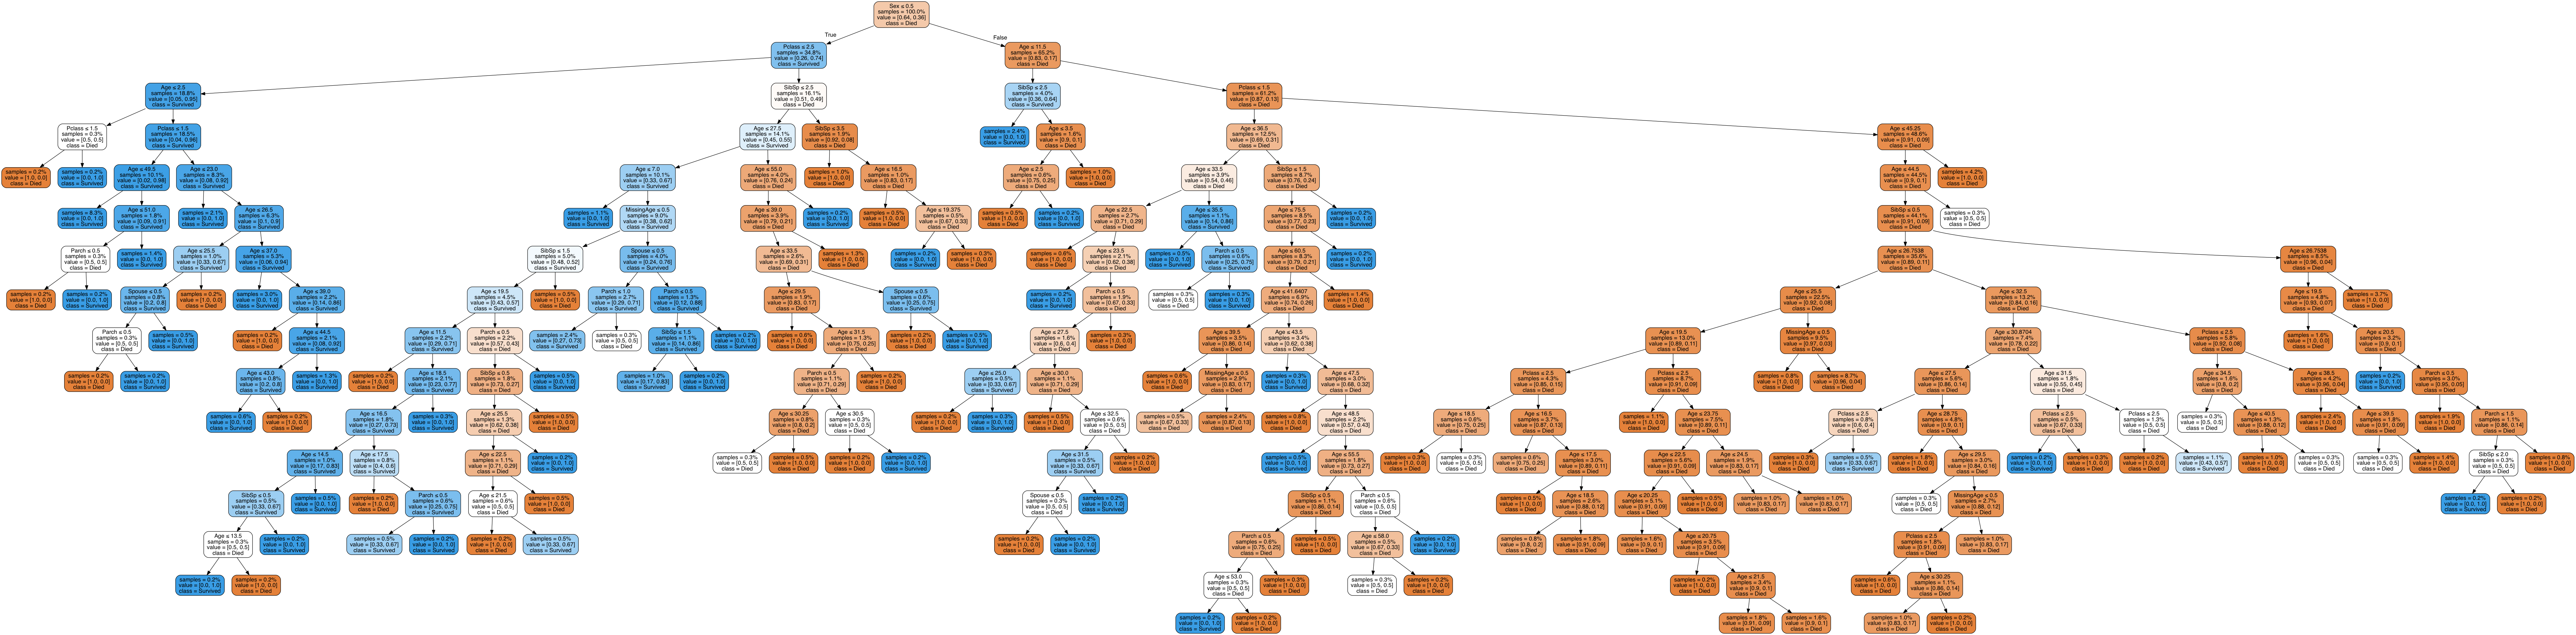

In [51]:
# Run the visualization
visualize_tree(ctree, features)

Let's make a smaller tree that's easier to interpret

In [52]:
# Create a decision tree classifier instance with a limitation on the tree depth
ctree = tree.DecisionTreeClassifier(random_state=1, max_depth = 2)

In [53]:
# Fit the decision tree classifer
ctree.fit(train.drop('Survived', axis=1), train['Survived'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')

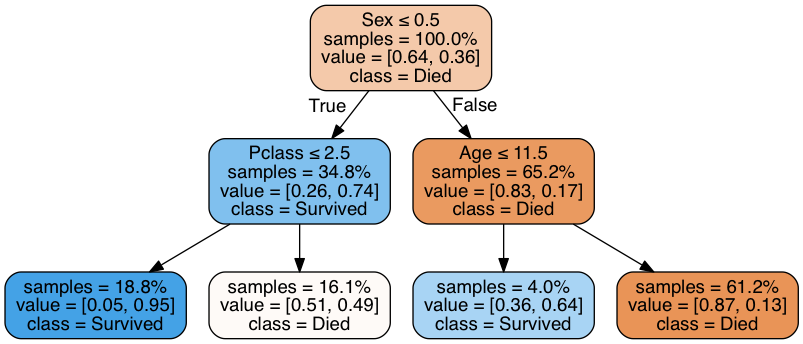

In [54]:
visualize_tree(ctree, features, proportion = True)

* You will notice that the right side of the chart is male, which has a higher death rate, and the left side is female, which has a higher survival rate
* Notice that having a large family is correlated with a higher death rate, although these are based on small sample sizes.
* Age (12yrs) is second node for men, indicating that boys had higher suvival rates than men.
* Class (1,2 vs. 3) is second node for women, indicating that women in the first two classes had higher survival rates.

#### Evaluating Accuracy

In [55]:
# Predict what will happen for 3rd class woman
ctree.predict_proba(np.array([[3, 0, 25, 0, 0, 0, 0]]))

array([[ 0.51,  0.49]])

In [56]:
features

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'MissingAge', 'Spouse']

In [57]:
# Predict what will happen for a 1st class man
ctree.predict_proba(np.array([[1, 1, 25, 0, 0, 0, 0]]))

array([[ 0.86614173,  0.13385827]])

In [58]:
# Calculate in-sample accuracy
preds = ctree.predict(train.drop('Survived', axis=1))
metrics.accuracy_score(train['Survived'], preds)

0.8154093097913323

In [59]:
# Calculate out-of-sample accuracy
preds = ctree.predict(test.drop('Survived', axis=1))
metrics.accuracy_score(test['Survived'], preds)

0.7350746268656716

In [60]:
# Confusion matrix
pd.crosstab(test['Survived'], preds, rownames=['actual'], colnames=['predicted'])

predicted    0   1
actual            
0          143  10
1           61  54

In [61]:
# Make predictions on the test set using predict_proba
probs = ctree.predict_proba(test.drop('Survived', axis=1))[:,1]

# Calculate the AUC metric
metrics.roc_auc_score(test['Survived'], probs)

0.76876953680022753

# Determining the optimal tree size

In [62]:
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV

In [63]:
# check CV score for max depth = 3
ctree = tree.DecisionTreeClassifier(max_depth=3)
np.mean(cross_val_score(ctree, d.drop('Survived', axis = 1), d['Survived'], cv=5, scoring='roc_auc'))

0.83608368937740796

In [64]:
# check CV score for max depth = 10
ctree = tree.DecisionTreeClassifier(max_depth=10)
np.mean(cross_val_score(ctree, d.drop('Survived', axis = 1), d['Survived'], cv=5, scoring='roc_auc'))

0.81194713980889155

In [65]:
# Conduct a grid search for the best tree depth
ctree = tree.DecisionTreeClassifier(random_state=10)
depth_range = list(range(1, 20))
param_grid = dict(max_depth=depth_range)
grid = GridSearchCV(ctree, param_grid, cv=5, scoring='accuracy')
grid.fit(d.drop('Survived', axis = 1), d['Survived'])

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=10, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

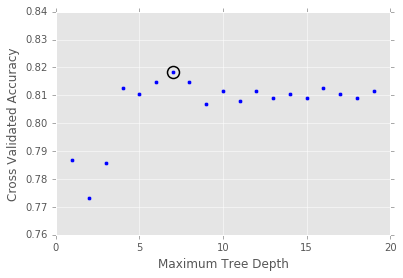

In [66]:
# Check out the scores of the grid search
grid_mean_scores = [result[1] for result in grid.grid_scores_]

# Plot the results of the grid search
plt.scatter(depth_range, grid_mean_scores)
plt.plot(grid.best_params_['max_depth'], grid.best_score_, 
         'o', markersize=12, markeredgewidth=1.5,
         markerfacecolor='None')
plt.ylabel('Cross Validated Accuracy')
plt.xlabel('Maximum Tree Depth')
plt.show()

In [67]:
# Conduct a grid search for the best tree depth
ctree = tree.DecisionTreeClassifier(random_state=10)
depth_range = list(range(2, 20))
param_grid = dict(max_leaf_nodes=depth_range)
grid = GridSearchCV(ctree, param_grid, cv=5, scoring='roc_auc')
grid.fit(d.drop('Survived', axis = 1), d['Survived'])

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=10, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

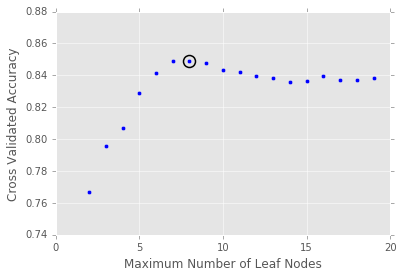

In [68]:
# Check out the scores of the grid search
grid_mean_scores = [result[1] for result in grid.grid_scores_]

# Plot the results of the grid search
plt.scatter(depth_range, grid_mean_scores)
plt.plot(grid.best_params_['max_leaf_nodes'], grid.best_score_, 
         'o', markersize=12, markeredgewidth=1.5,
         markerfacecolor='None')
plt.ylabel('Cross Validated Accuracy')
plt.xlabel('Maximum Number of Leaf Nodes')
plt.show()

In [69]:
# Get the best estimator
best = grid.best_estimator_

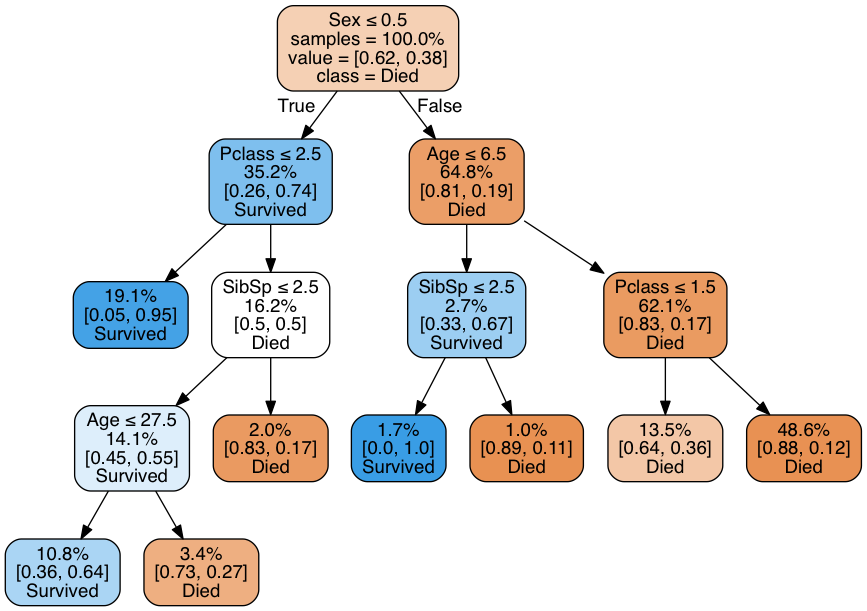

In [70]:
# Visualize the best estimator with some modified visualization paramters
visualize_tree(best, features, impurity = False, label = 'root')

# Strengths and Weaknesses

**Strengths**
* The nature of its output provides the decision tree algorithm with a degree of interpretability that other more complex algorithms don’t provide
* Understanding how decision trees work is foundational to understanding how more complex, and widely-used models work.


**Weaknesses**
* The decision tree tends to perform worse than more sophisticated modeling techniques due to their unstability
* Decision trees require tuning to avoid overfitting

# Documentation
* Documentation for [`DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). 
* Check out the documentation for `max_features`, `max_leaf_nodes`, and `splitter` for additional flexibility in fitting the model
* Scikit Learn provides an implementation for continuous outputs:  [`DecisionTreeRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor) 

# Resources
* Chapter 8.1 of An Introduction to Statistical Learning also covers the basics of Classification and Regression Trees
* The scikit-learn [documentation](http://scikit-learn.org/stable/modules/tree.html) has a detailed tutorial that includes a discussion of the strengths and weaknesses of Trees.
* For those of you with background in javascript, d3.js has a nice tree layout that would make more presentable tree diagrams:
   * Here is a link to a [static version](http://bl.ocks.org/mbostock/4339184), as well as a link to a [dynamic version](http://bl.ocks.org/mbostock/4339083) with collapsable nodes.
   * If this is something you are interested in, Gary Sieling wrote a nice [function](http://www.garysieling.com/blog/rending-scikit-decision-trees-d3-js) in python to take the output of a scikit-learn tree and convert into json format.
   * If you are intersted in learning d3.js, this a good [tutorial](http://www.d3noob.org/2014/01/tree-diagrams-in-d3js_11.html) for understanding the building blocks of a decision tree. Here is another [tutorial](http://blog.pixelingene.com/2011/07/building-a-tree-diagram-in-d3-js/) focusing on building a tree diagram in d3.js.
* Dr. Justin Esarey from Rice University has a nice [video lecture](https://www.youtube.com/watch?v=HW7Aib842Oo&hd=1) on CART that also includes an [R code walkthrough](http://jee3.web.rice.edu/cart-and-random-forests.r)